   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
--

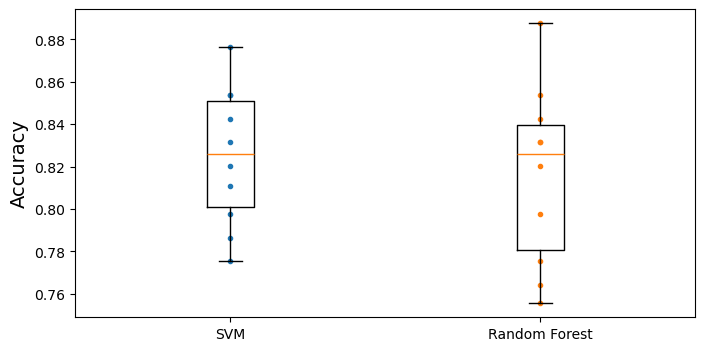

           Survived
AgeBucket          
0.0        0.576923
15.0       0.362745
30.0       0.423256
45.0       0.404494
60.0       0.240000
75.0       1.000000
---

                  Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000
---



In [13]:
#
import os
import re
import sys
import tarfile
import email
import email.policy

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import urllib.request

%matplotlib inline

#
from collections import Counter
from html import unescape
from scipy.ndimage import shift
from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

#
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

#
def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

#
fetch_titanic_data()    

#
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

#
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

#
print(train_data.head())
print("---")
print()

#
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

#
print(train_data.info())
print("---")
print()

#
train_data[train_data["Sex"]=="female"]["Age"].median()

#
print(train_data.describe())
print("---")
print()

#
print(train_data["Survived"].value_counts())
print("---")
print()

#
print(train_data["Pclass"].value_counts())
print("---")
print()

#
print(train_data["Sex"].value_counts())
print("---")
print()

#
print(train_data["Embarked"].value_counts())
print("---")
print()

#
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

#
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

#
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

#
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
print(X_train)
print("---")
print()

#
y_train = train_data["Survived"]

#
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

#
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

#
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
print(forest_scores.mean())
print("---")
print()

#
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print(svm_scores.mean())
print("---")
print()

#
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=["SVM", "Random Forest"])  # actualizado
plt.ylabel("Accuracy", fontsize=14)
plt.show()

#
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
print(train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean())
print("---")
print()
    
#
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
print(train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean())
print("---")
print()


# 1. IMPORTS & SETUP

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. LOAD DATA

In [5]:
data = pd.read_csv('../datasets/train.csv')

# 3. EXPLORATORY DATA ANALYSIS (EDA)

In [6]:
print(data.head())
print(data.info())
print(data.describe())
print("Missing values per column:\n", data.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# 4. PREPROCESSING

In [8]:
titanic = data.drop(['Cabin', 'Ticket', 'Name'], axis=1)  # Drop high-missing and less useful columns
titanic = titanic.dropna()  #drop rows with missing values

# Separate features and target
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']

# Identify types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# 5. TRAIN-TEST SPLIT

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. MODEL PIPELINE AND TRAINING

In [10]:
model = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'Embarked'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

# 7. PREDICTION AND EVALUATION

In [11]:
y_pred = model.predict(X_test)

print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.7902097902097902

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        85
           1       0.74      0.74      0.74        58

    accuracy                           0.79       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143


Confusion Matrix:
 [[70 15]
 [15 43]]


# 8. FEATURE IMPORTANCE (OPTIONAL)

In [12]:
# Logistic Regression coefficients for interpretation
coefs = model.named_steps['clf'].coef_[0]
feature_names = (
    numeric_features + 
    list(model.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(categorical_features))
)
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
print("\nTop features by absolute coefficient:\n", 
      coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index).head(10))


Top features by absolute coefficient:
        feature      coef
6     Sex_male -2.483945
1       Pclass -1.019355
2          Age -0.599936
8   Embarked_S -0.478041
7   Embarked_Q -0.361805
3        SibSp -0.229601
0  PassengerId  0.126794
5         Fare -0.038044
4        Parch -0.035144
